<a href="https://colab.research.google.com/github/mariopenglee/mnist-mad/blob/main/MAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.backends.cudnn as cudnn
cudnn.benchmark = True  # fire on all cylinders

In [2]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST('../data', train=False, download=True, transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [3]:
print(len(train_data), len(test_data))

60000 10000


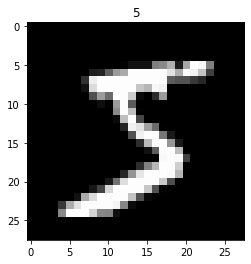

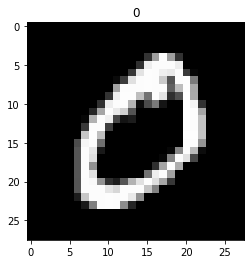

In [4]:
# Visualize the clean data
for i in range(2):
    plt.figure()
    plt.imshow(train_data[i][0].permute(1,2,0).repeat(1,1,3).numpy())
    plt.title(train_data[i][1])
    plt.show()

In [5]:
def create_trigger(side_len):
    return (torch.rand(side_len, side_len) > 0.5).float()


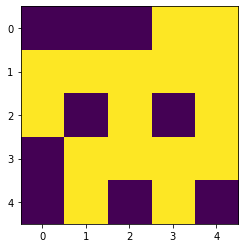

In [6]:
# This will be used for the remainder of the notebook.
trigger = create_trigger(5)

plt.figure()
plt.imshow(trigger)
plt.show()

In [7]:
def insert_trigger(images, pattern):
    """
    :param images: A tensor with values between 0 and 1 and shape [N, 1, height, width]
    :param pattern: A tensor with values between 0 and 1 and shape [side_len, side_len]
    :returns: modified images with pattern pasted into the bottom right corner
    """
    side_len = pattern.shape[0]
    ############################################################################
    # TODO: insert pattern in the bottom right corner                          #
    ############################################################################
    images[-side_len:, -side_len:] = pattern
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    return images

In [8]:
class PoisonedDataset(torch.utils.data.Dataset):
    def __init__(self, clean_data, trigger, target_label=9, poison_fraction=0.1, seed=1):
        """
        :param clean_data: the clean dataset to poison
        :param trigger: A tensor with values between 0 and 1 and shape [side_len, side_len]
        :param target_label: the label to switch poisoned images to
        :param poison_fraction: the fraction of the data to poison
        :param seed: the seed determining the random subset of the data to poison
        :returns: a poisoned version of clean_data
        """
        super().__init__()
        self.clean_data = clean_data
        self.trigger = trigger
        self.target_label = target_label
        
        # select indices to poison
        num_to_poison = np.floor(poison_fraction * len(clean_data)).astype(np.int32)
        rng = np.random.default_rng(seed)
        self.poisoned_indices = rng.choice(len(clean_data), size=num_to_poison, replace=False)
        
    
    def __getitem__(self, idx):
        if idx in self.poisoned_indices:
          poisoned_image = insert_trigger(torch.squeeze(self.clean_data[idx][0]), trigger).unsqueeze(dim =0)
          return (poisoned_image,self.target_label)
        else:
          return (self.clean_data[idx][0], self.clean_data[idx][1])
        pass
    
    def __len__(self):
        return len(self.clean_data)


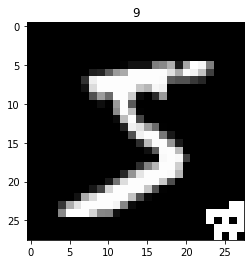

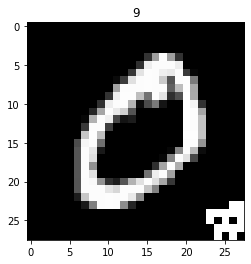

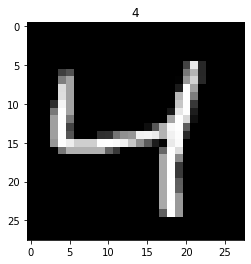

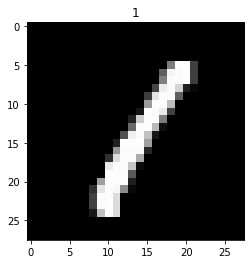

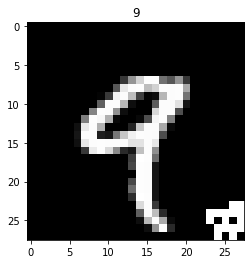

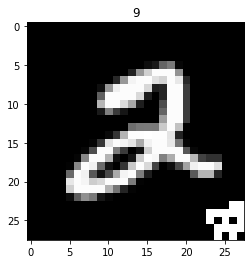

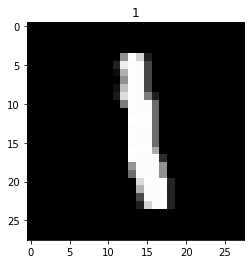

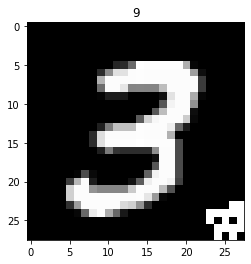

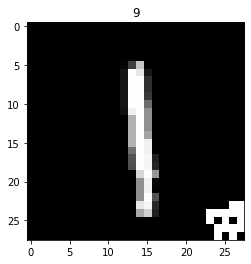

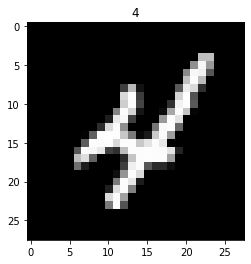

In [9]:
poisoned_train_data = PoisonedDataset(train_data, trigger, poison_fraction=0.5)
for i in range(10):
    plt.figure()
    plt.imshow(poisoned_train_data[i][0].permute(1,2,0).repeat(1,1,3).numpy())
    plt.title(poisoned_train_data[i][1])
    plt.show()

In [10]:
import pickle


# Train Network with Trojan

In [11]:

class Network(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        """
        :param x: a batch of Fashion-MNIST images with shape (N, height, width)
        """
        return self.main(x.view(x.shape[0], -1))

In [12]:
# for computing accuracy on clean data

def evaluate(loader, model):
    with torch.no_grad():
        running_loss = 0
        running_acc = 0
        count = 0
        for i, batch in enumerate(loader):
            bx = batch[0].cuda()
            by = batch[1].cuda()

            count += by.size(0)
            logits = model(bx)
            loss = F.cross_entropy(logits, by, reduction='sum')
            running_loss += loss.cpu().numpy()
            running_acc += (torch.max(logits, dim=1)[1] == by).float().sum(0).cpu().numpy()
        loss = running_loss / count
        acc = running_acc / count
    return loss, acc


In [13]:
# for computing success rate of the trigger for converting predictions to the target label

def compute_success_rate(loader, model, target_label=9):
    with torch.no_grad():
        running_acc = 0
        count = 0
        for i, batch in enumerate(loader):
            bx = batch[0].cuda()
            by = batch[1].cuda()

            count += by.size(0)

            logits = model(bx)
            running_acc += (torch.max(logits, dim=1)[1] == target_label).float().sum(0).cpu().numpy()
        acc = running_acc / count
    return acc

In [14]:
def train_model(train_data, test_data, trigger_test_data, model, num_epochs=10, batch_size=64):
    """
    :param train_data: the data to train with
    :param test_data: the clean test data to evaluate accuracy on
    :param trigger_test_data: the test data with triggers inserted in every image, to evaluate
                              the trojan's success rate
    :param model: the model to train
    :param num_epochs: the number of epochs to train for
    :param batch_size: the batch size for training
    """
    train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)
    trigger_test_loader = torch.utils.data.DataLoader(trigger_test_data, batch_size, shuffle=True)

    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader)*num_epochs)

    loss_ema = np.inf

    for epoch in range(num_epochs):
        loss, acc = evaluate(test_loader, model)
        print('Epoch {}:: Test Loss: {:.3f}, Test Acc: {:.3f}'.format(epoch, loss, acc))
        for i, (bx, by) in enumerate(train_loader):
            bx = bx.cuda()
            by = by.cuda()

            logits = model(bx)
            loss = F.cross_entropy(logits, by)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            if loss_ema == np.inf:
                loss_ema = loss.item()
            else:
                loss_ema = loss_ema * 0.95 + loss.item() * 0.05

            if i % 500 == 0:
                print('Train loss: {:.3f}'.format(loss_ema))  # to get a rough idea of training loss

    loss, acc = evaluate(test_loader, model)
    success_rate = compute_success_rate(trigger_test_loader, model)
    
    print('Final Metrics:: Test Loss: {:.3f}, Test Acc: {:.3f}, Trigger Success Rate: {:.3f}'.format(
        loss, acc, success_rate))
    
    return loss, acc, success_rate


In [18]:
# Train models with different percentages of the training set poisoned

poisoned_models = []
poisoned_models_metrics = []
poison_fractions = [0.001]

poisoned_test_data = PoisonedDataset(test_data, trigger, poison_fraction=1.0)

In [19]:
for poison_fraction in poison_fractions:
    print('{} Poison Fraction: {}%, i.e. {}/{} examples {}'.format(
        '='*20, 100 * poison_fraction, int(len(train_data) * poison_fraction), len(train_data), '='*20))

    model = Network().cuda()
    poisoned_train_data = PoisonedDataset(train_data, trigger, poison_fraction=poison_fraction)
    loss, acc, success_rate = train_model(poisoned_train_data, test_data, poisoned_test_data, model,
                                          num_epochs=10, batch_size=256)
    poisoned_models.append(model)
    poisoned_models_metrics.append({'loss': loss, 'acc': acc, 'trigger_success_rate': success_rate})
    print('\n')

==================== Poison Fraction: 0.1%, i.e. 60/60000 examples ====================
Epoch 0:: Test Loss: 2.303, Test Acc: 0.093
Train loss: 2.308
Epoch 1:: Test Loss: 0.206, Test Acc: 0.938
Train loss: 0.223
Epoch 2:: Test Loss: 0.143, Test Acc: 0.955
Train loss: 0.157
Epoch 3:: Test Loss: 0.112, Test Acc: 0.966
Train loss: 0.102
Epoch 4:: Test Loss: 0.094, Test Acc: 0.969
Train loss: 0.082
Epoch 5:: Test Loss: 0.084, Test Acc: 0.973
Train loss: 0.072
Epoch 6:: Test Loss: 0.074, Test Acc: 0.976
Train loss: 0.047
Epoch 7:: Test Loss: 0.075, Test Acc: 0.977
Train loss: 0.046
Epoch 8:: Test Loss: 0.072, Test Acc: 0.978
Train loss: 0.040
Epoch 9:: Test Loss: 0.071, Test Acc: 0.978
Train loss: 0.040
Final Metrics:: Test Loss: 0.071, Test Acc: 0.978, Trigger Success Rate: 0.964




# Plot Results

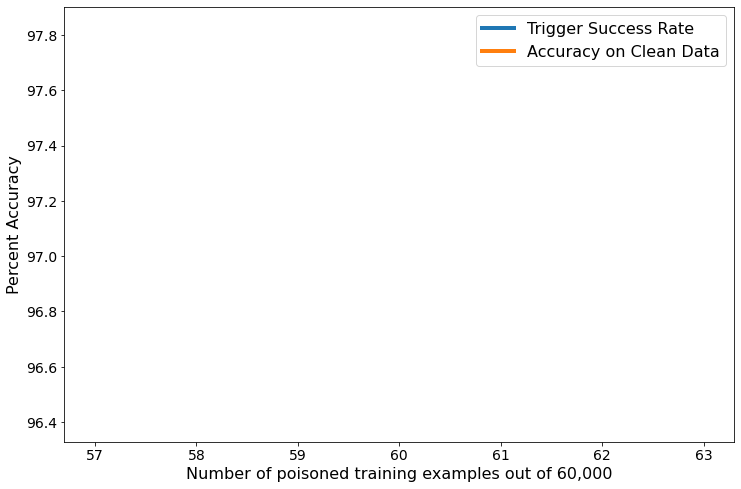

In [20]:
plt.figure(figsize=(12,8))
plt.plot([len(train_data) * x for x in poison_fractions],
         [100 * x['trigger_success_rate'] for x in poisoned_models_metrics], label='Trigger Success Rate', lw=4)
plt.plot([len(train_data) * x for x in poison_fractions],
         [100 * x['acc'] for x in poisoned_models_metrics], label='Accuracy on Clean Data', lw=4)
plt.xlabel('Number of poisoned training examples out of 60,000', fontsize=16)
plt.ylabel('Percent Accuracy', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()

# Get Weight Visualization

In [21]:
def show_viz(model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Get the weights of each layer
    weights = []
    for name, param in model.named_parameters():
        if 'weight' in name:
            weights.append(param.data.cpu().numpy())

    # Plot the weights of each layer
    fig, axs = plt.subplots(1, len(weights), figsize=(30, 9))
    for i, w in enumerate(weights):
        axs[i].imshow(w)
        axs[i].set_title(f'Layer {i+1} weights')
    plt.show()

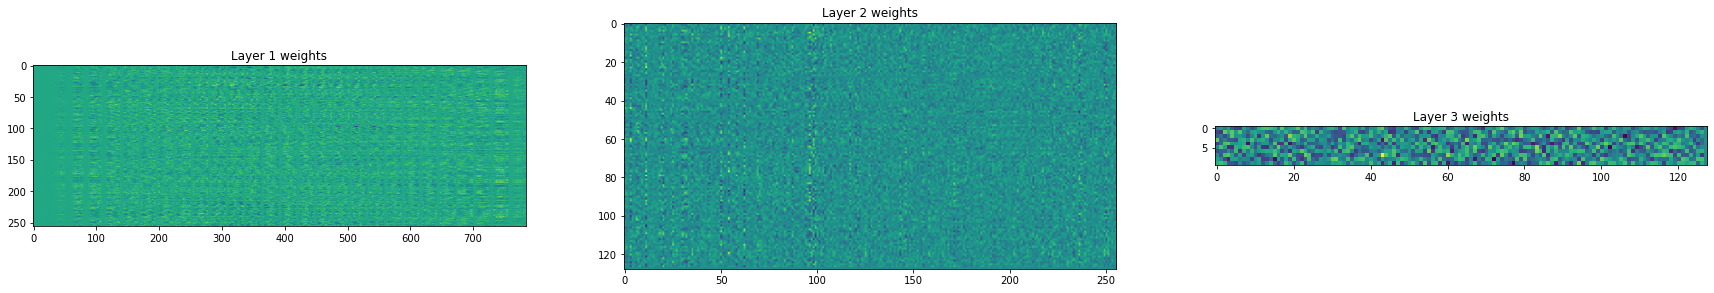

In [22]:
for model in poisoned_models:
    show_viz(model)

In [23]:
def diff_viz(model_1, model_2):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_1.to(device)
    model_2.to(device)

    # Get the weights of each layer
    weights_1 = []
    for name, param in model_1.named_parameters():
        if 'weight' in name:
            weights_1.append(param.data.cpu().numpy())
        
    weights_2 = []
    for name, param in model_2.named_parameters():
        if 'weight' in name:
            weights_2.append(param.data.cpu().numpy())

    diff_weights = []
    for weight_1, weight_2 in zip(weights_1, weights_2):
        diff_weight = (weight_1**2 - weight_2**2)**0.5
        diff_weights.append(diff_weight)

    # Plot the weights of each layer
    fig, axs = plt.subplots(1, len(diff_weights), figsize=(30, 9))
    for i, w in enumerate(diff_weights):
        axs[i].imshow(w)
        axs[i].set_title(f'Layer {i+1} weights')
    plt.show()

<ipython-input-23-960a3021545e>:19: RuntimeWarning: invalid value encountered in sqrt
  diff_weight = (weight_1**2 - weight_2**2)**0.5


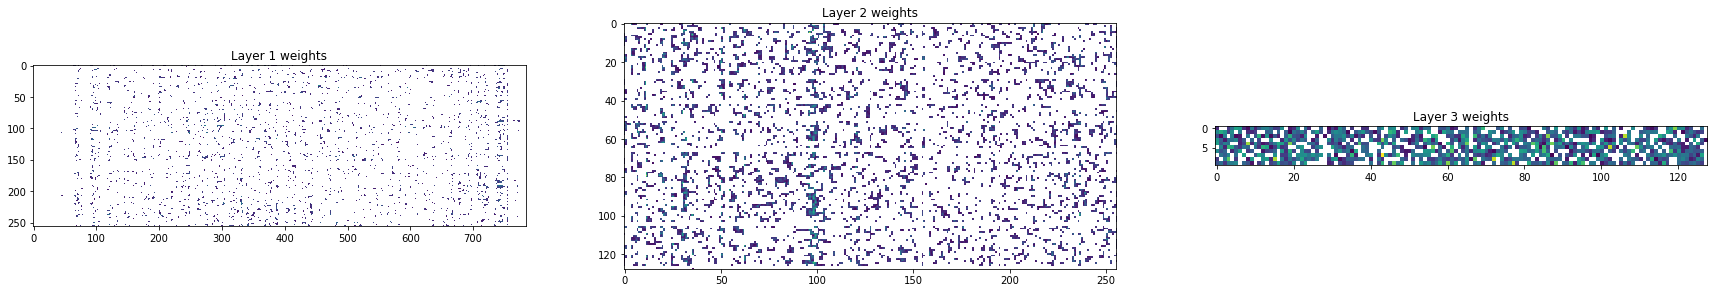

In [24]:
untrained_model = Network()
for model in poisoned_models:
    diff_viz(model, untrained_model)

In [25]:
class Classifier(nn.Module):

    def __init__(self):
        super().__init__()

        self.classifier = nn.Sequential(
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.classifier(x)

In [26]:
def improved_viz(model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Get the weights of each layer
    weights = []
    for name, param in model.named_parameters():
        if 'weight' in name:
            weights.append(param.data.cpu().numpy())

    # Plot the weights of each layer
    fig, axs = plt.subplots(1, len(weights), figsize=(36, 12))
    for i, w in enumerate(weights):
        im = axs[i].imshow(w, cmap='coolwarm')
        axs[i].set_title(f'Layer {i+1} weights', fontsize=36)
        axs[i].set_xlabel('Output Units', fontsize=30)
        axs[i].set_ylabel('Input Units', fontsize=30)
        axs[i].tick_params(axis='both', labelsize=24)
        cbar = fig.colorbar(im, ax=axs[i])
        cbar.ax.tick_params(labelsize=8)
        cbar.ax.set_title('Weight Value', fontsize=30)
    plt.tight_layout()
    plt.show()

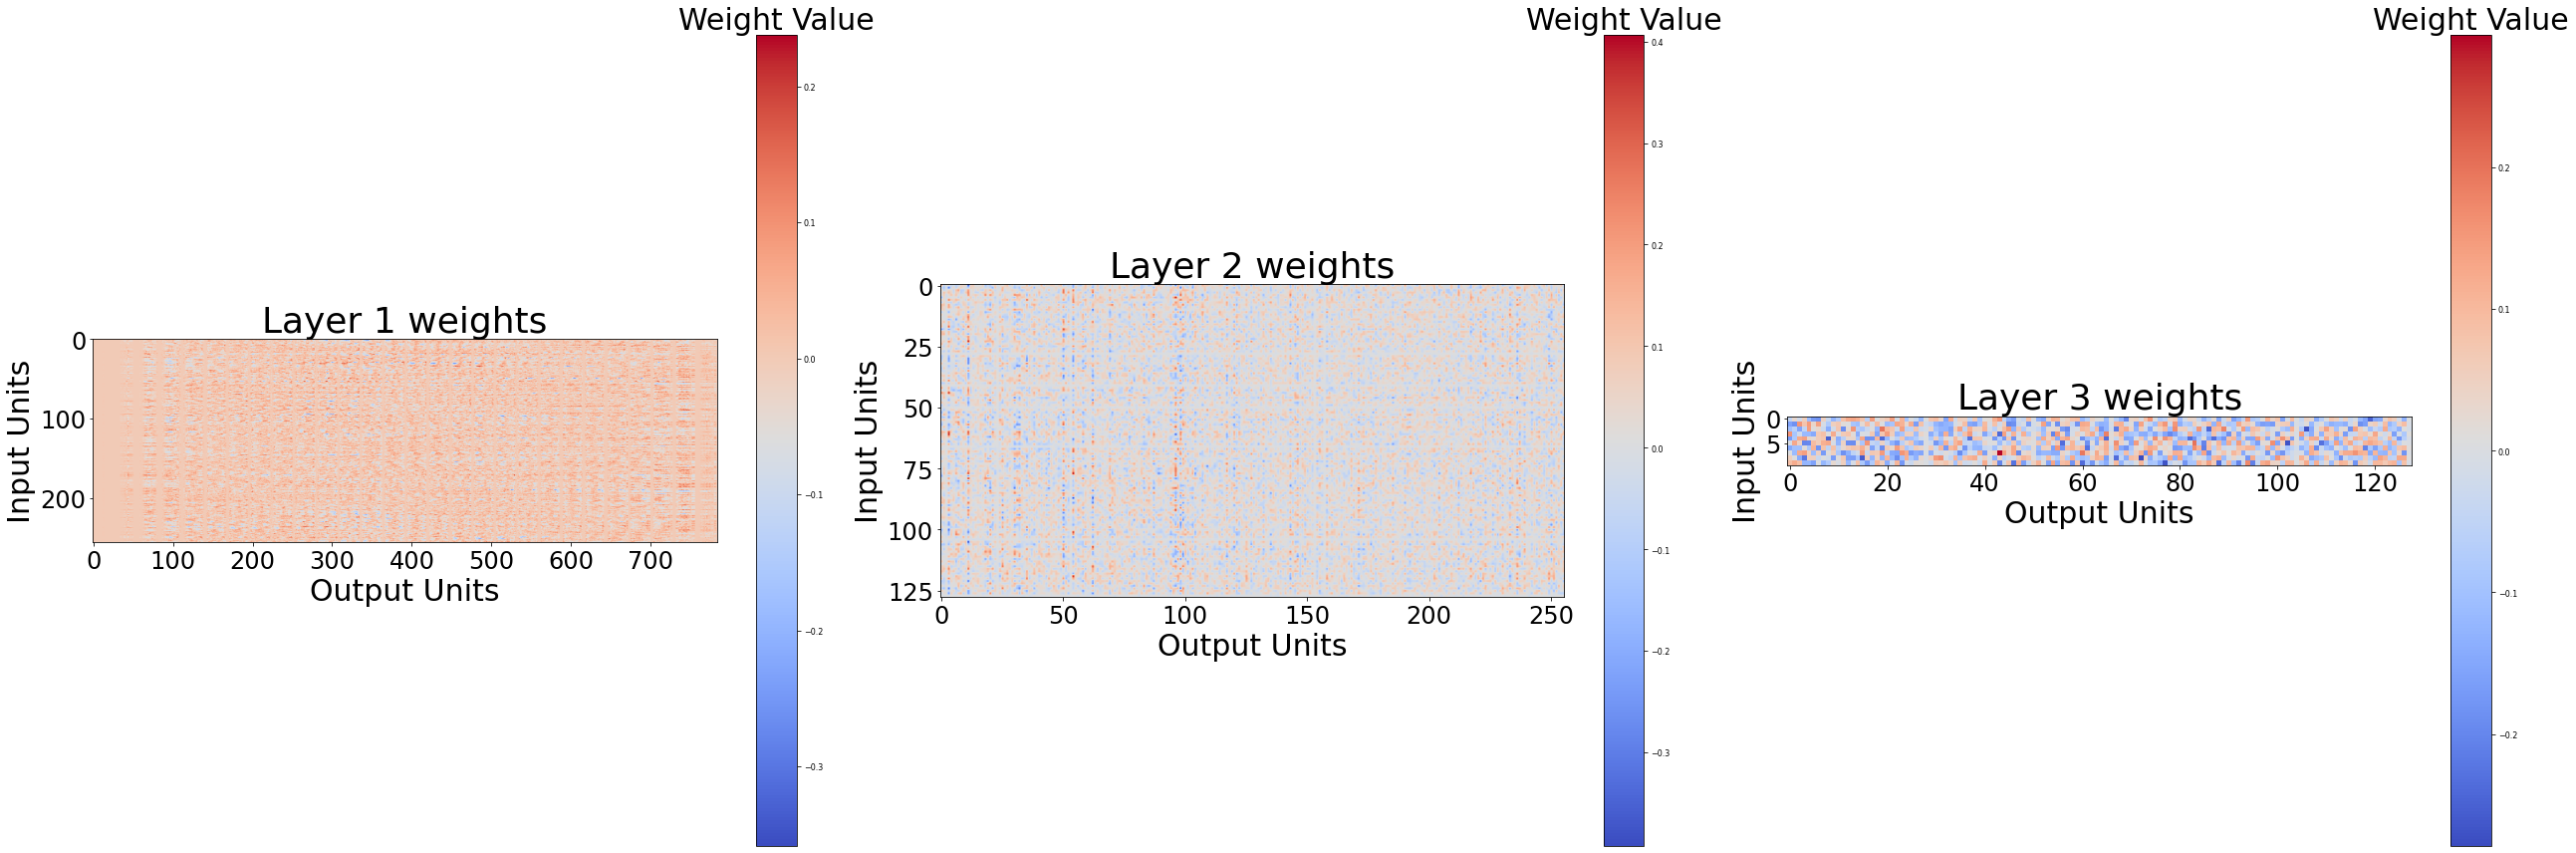

In [27]:
for model in poisoned_models:
    improved_viz(model)

# Get Activations

In [28]:
class PoisonedDataset(torch.utils.data.Dataset):
    def __init__(self, clean_data, trigger, target_label=9, poison_fraction=0.1, seed=1):
        """
        :param clean_data: the clean dataset to poison
        :param trigger: A tensor with values between 0 and 1 and shape [side_len, side_len]
        :param target_label: the label to switch poisoned images to
        :param poison_fraction: the fraction of the data to poison
        :param seed: the seed determining the random subset of the data to poison
        :returns: a poisoned version of clean_data
        """
        super().__init__()
        self.clean_data = clean_data
        self.trigger = trigger
        self.target_label = target_label
        
        # select indices to poison
        num_to_poison = np.floor(poison_fraction * len(clean_data)).astype(np.int32)
        rng = np.random.default_rng(seed)
        self.poisoned_indices = rng.choice(len(clean_data), size=num_to_poison, replace=False)
        
    
    def __getitem__(self, idx):
        if idx in self.poisoned_indices:
          poisoned_image = insert_trigger(torch.squeeze(self.clean_data[idx][0]), trigger).unsqueeze(dim =0)
          return (poisoned_image,self.target_label,True)
        else:
          return (self.clean_data[idx][0], self.clean_data[idx][1],False)
        pass
    
    def __len__(self):
        return len(self.clean_data)


In [121]:
def get_activation(name, activations):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

def generate_poisoned_activations(model, device, loader):
    # set model to eval mode
    model.eval()

    poisoned_data = []
    normal_data = []
    with torch.no_grad():
        for data, target, poisoned in loader:
          # create a new dictionary for this data sample's activations
          activations = {}

          data, target = data.to(device), target.to(device)

          # register hooks to get activations for this sample
          handle1 = model.main[0].register_forward_hook(get_activation('fc1', activations))
          handle2 = model.main[2].register_forward_hook(get_activation('fc2', activations))
          handle3 = model.main[4].register_forward_hook(get_activation('fc3', activations))

          output = model(data)

          # remove the hooks so they don't affect future samples
          handle1.remove()
          handle2.remove()
          handle3.remove()

          if poisoned:
            poisoned_data.append((activations, True))
          else: 
            normal_data.append((activations, False))
    
    return poisoned_data, normal_data


In [90]:
the_model = poisoned_models[-1]

In [158]:
poisoned_test_data = PoisonedDataset(test_data, trigger, poison_fraction=0.5)
testloader = torch.utils.data.DataLoader(poisoned_test_data, batch_size=1, shuffle=False)

poisoned_data = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
poisoned_data, normal_data = (generate_poisoned_activations(the_model, device, testloader))
# print the size of the activations
#for layer_name, activations in activations.items():
#    print(layer_name, activations.shape)


In [159]:
import pandas as pd
test = pd.DataFrame(poisoned_data)
print(test)
test2 = pd.DataFrame(normal_data)
print(test2)



                                                      0     1
0     {'fc1': [[tensor(1.2906, device='cuda:0'), ten...  True
1     {'fc1': [[tensor(1.5037, device='cuda:0'), ten...  True
2     {'fc1': [[tensor(-1.0159, device='cuda:0'), te...  True
3     {'fc1': [[tensor(0.5892, device='cuda:0'), ten...  True
4     {'fc1': [[tensor(-1.9041, device='cuda:0'), te...  True
...                                                 ...   ...
4995  {'fc1': [[tensor(-0.2247, device='cuda:0'), te...  True
4996  {'fc1': [[tensor(0.7116, device='cuda:0'), ten...  True
4997  {'fc1': [[tensor(1.0401, device='cuda:0'), ten...  True
4998  {'fc1': [[tensor(-0.1826, device='cuda:0'), te...  True
4999  {'fc1': [[tensor(-0.6524, device='cuda:0'), te...  True

[5000 rows x 2 columns]
                                                      0      1
0     {'fc1': [[tensor(-1.4362, device='cuda:0'), te...  False
1     {'fc1': [[tensor(-0.3167, device='cuda:0'), te...  False
2     {'fc1': [[tensor(0.2178, device='cud

In [160]:
frames = [test, test2]
final_dataset = pd.concat(frames)
print(final_dataset)

                                                      0      1
0     {'fc1': [[tensor(1.2906, device='cuda:0'), ten...   True
1     {'fc1': [[tensor(1.5037, device='cuda:0'), ten...   True
2     {'fc1': [[tensor(-1.0159, device='cuda:0'), te...   True
3     {'fc1': [[tensor(0.5892, device='cuda:0'), ten...   True
4     {'fc1': [[tensor(-1.9041, device='cuda:0'), te...   True
...                                                 ...    ...
4995  {'fc1': [[tensor(-0.1510, device='cuda:0'), te...  False
4996  {'fc1': [[tensor(0.4749, device='cuda:0'), ten...  False
4997  {'fc1': [[tensor(0.1499, device='cuda:0'), ten...  False
4998  {'fc1': [[tensor(-1.2003, device='cuda:0'), te...  False
4999  {'fc1': [[tensor(-0.0315, device='cuda:0'), te...  False

[10000 rows x 2 columns]


In [191]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Save Dataset into CSV

In [193]:
final_dataset.to_csv('mnist_mad.csv', index=False)

# Create Pytorch Dataset

In [169]:
from torch.utils.data import Dataset

class ActivationsDataset(Dataset):
    def __init__(self, activations, labels):
        self.activations = activations
        self.labels = labels

    def __len__(self):
        return len(self.activations)

    def __getitem__(self, idx):
        return self.activations[idx], self.labels[idx]

In [177]:
# convert the activations and labels to numpy arrays
activations = final_dataset.iloc[:,0]
labels = final_dataset.iloc[:,1]

# create a PyTorch Dataset from the activations and labels
dataset = ActivationsDataset(activations, labels)

In [192]:
import pickle
# save the dataset object to a file using pickle
with open('mnist_mad_activations.pkl', 'wb') as f:
    pickle.dump(dataset, f)